In [1]:
!pip install super-gradients==3.1.0

  Using cached Pillow-9.5.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)


  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio-converter 0.0.40 requires Pillow==9.0.1, but you have pillow 9.5.0 which is incompatible.


In [2]:
!pip install imutils

In [3]:
import torch
torch.__version__

'1.11.0+cu113'

In [4]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [5]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

The console stream is logged into /home/gm/sg_logs/console.log


[2023-05-17 14:19:26] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-05-17 14:19:31] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-17 14:19:31] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-17 14:19:31] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-17 14:19:31] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [7]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [20]:
dataset_params = {
    'data_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/',
    'train_images_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/train/images/',
    'train_labels_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/train/labels/',
    'val_images_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/val/images/',
    'val_labels_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/val/labels/',
    'test_images_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/test/images/',
    'test_labels_dir':'/home/gm/Rajkiran/yolonas/obdetect/converted2k/test/labels/',
    'classes':['impacted_tooth','bone_loss','restorations','other','absent_tooth','dental_caries','attrition','periapical_abnormality','implants','position',
'prosthetics','root_stump','fracture','dental_caries_old','altered_morphology','microdontia','bone_loss_old','periapical_abnormality_old']
}

In [21]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

clear_output()

Caching annotations: 100%|██████████████████| 209/209 [00:00<00:00, 6596.16it/s]


In [23]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-17 14:48:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [24]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [25]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-17 14:49:32] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yolonas_run/console_May17_14_49_32.txt


[2023-05-17 14:49:36] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Dataset size:                 1668       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         208        (len(train_loader))
    - Gradient updates per epoch:   208        (len(train_loader) / batch_accumulate)

[2023-05-17 14:51:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-17 14:51:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0010215385118499398
[2023-05-17 14:54:14] INFO - base_sg_logger.py - Checkpoint saved in 

SUMMARY OF EPOCH 100
├── Training
│   ├── Ppyoloeloss/loss = 2.0185
│   │   ├── Best until now = 2.0232 (↘ -0.0047)
│   │   └── Epoch N-1      = 2.0236 (↘ -0.005)
│   ├── Ppyoloeloss/loss_cls = 0.884
│   │   ├── Best until now = 0.8846 (↘ -0.0006)
│   │   └── Epoch N-1      = 0.8882 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.9079
│   │   ├── Best until now = 0.9072 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.9072 (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.2722
│       ├── Best until now = 0.2727 (↘ -0.0005)
│       └── Epoch N-1      = 0.2727 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.084
    │   ├── Best until now = 0.0848 (↘ -0.0008)
    │   └── Epoch N-1      = 0.0657 (↗ 0.0183)
    ├── Map@0.50 = 0.2424
    │   ├── Best until now = 0.2258 (↗ 0.0165)
    │   └── Epoch N-1      = 0.1781 (↗ 0.0643)
    ├── Ppyoloeloss/loss = 2.2278
    │   ├── Best until now = 2.2509 (↘ -0.0231)
    │   └── Epoch N-1      = 2.2862 (↘ -0.0584)
    ├── Ppyoloeloss/loss_cls = 0.954
    │   ├── Best 

[2023-05-17 19:20:37] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [26]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/home/gm/Rajkiran/yolonas/checkpoints/my_first_yolonas_run/ckpt_best.pth")
                        #checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

[2023-05-22 13:23:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/gm/Rajkiran/yolonas/checkpoints/my_first_yolonas_run/ckpt_best.pth EMA checkpoint.


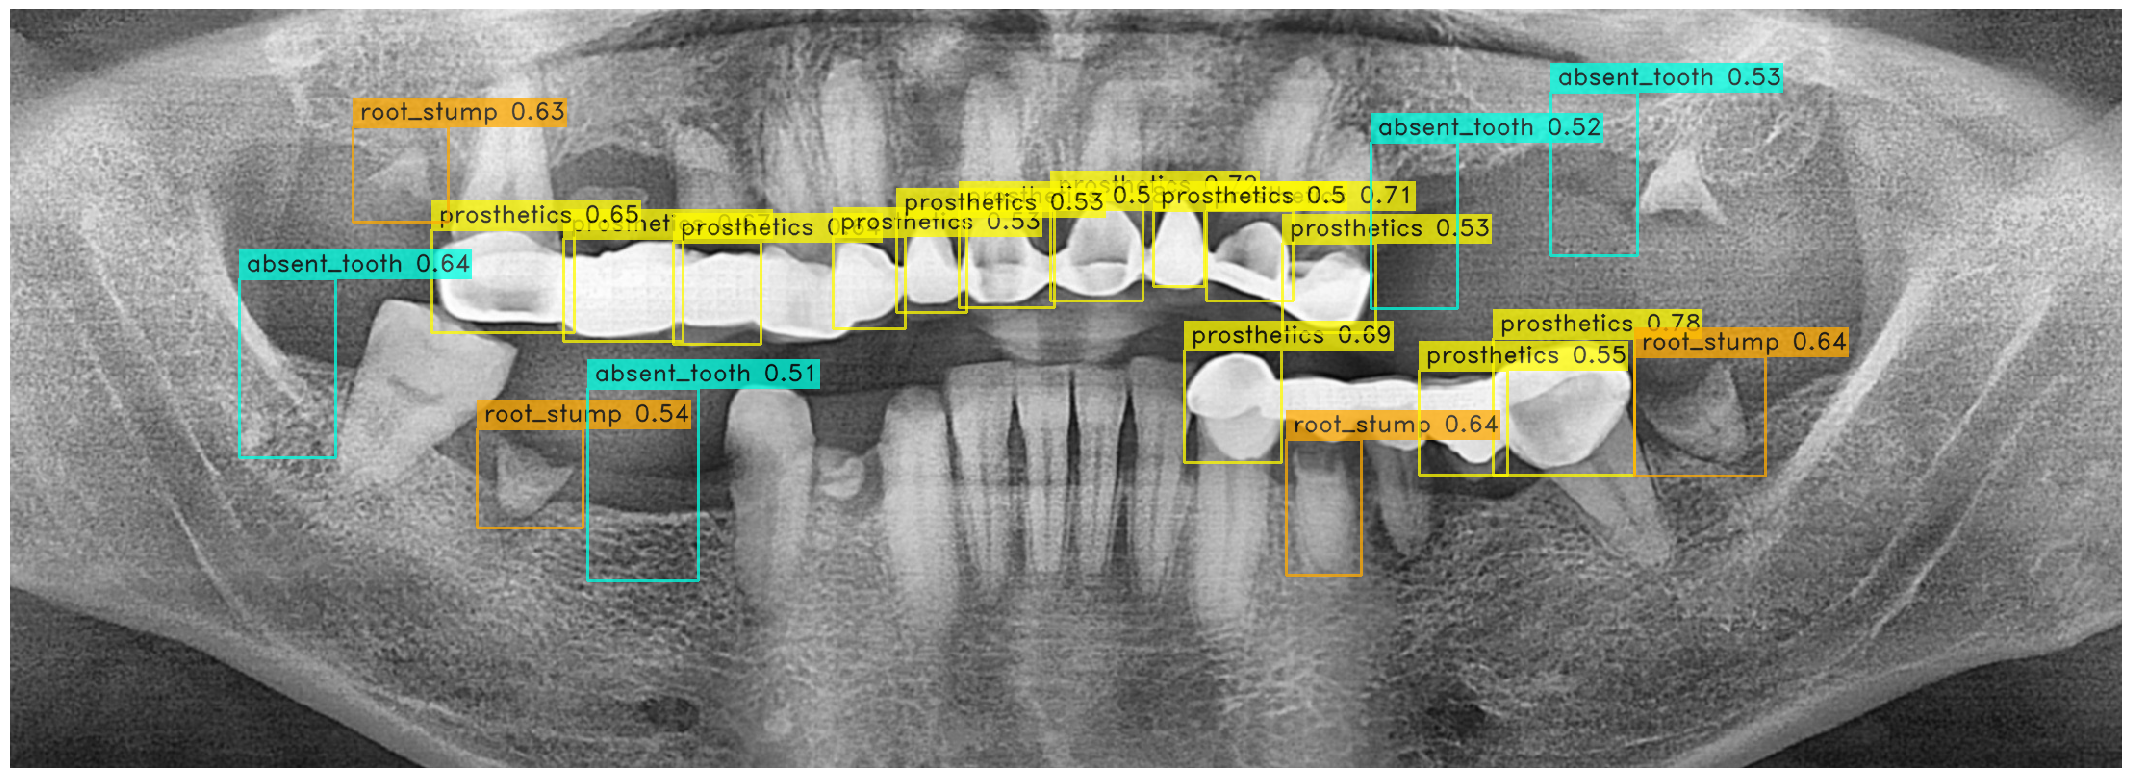

In [40]:
test_image = '/home/gm/Rajkiran/yolonas/obdetect/converted2k/test/images/399.jpg'
best_model.predict(test_image).show()
